In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

os.chdir('/content/drive/MyDrive/HRP')

Mounted at /content/drive


In [3]:
import pandas as pd
from tqdm import tqdm

csv_file = "ecgredone_data.csv"


total_lines = sum(1 for _ in open(csv_file)) - 1


chunks = []
chunksize = 1000
with tqdm(desc="Reading CSV in chunks", total=total_lines, unit="lines") as pbar:
    for chunk in pd.read_csv(csv_file, chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))


Reading CSV in chunks: 100%|██████████| 812700/812700 [02:01<00:00, 6677.56lines/s]


In [4]:
df_main = pd.concat(chunks, ignore_index=True)

In [5]:
def get_dataframe(disease_code):
  d_ids = set(df_main[df_main['Vals'] == disease_code]['Name'])
  print(f'There are {len(d_ids)} patients in the dataset')
  df_d = df_main[df_main['Name'].isin(d_ids)]
  return df_d


In [6]:
df_sinus = get_dataframe('426783006')
df_sinus_a = get_dataframe('164889003')

There are 5908 patients in the dataset
There are 422 patients in the dataset


In [7]:
from tqdm import tqdm
import numpy as np

def create_formatted(df, disease=0, lead_target=0):
    examples = []
    num_leads = 12
    lead_length = 5000

    for start_idx in tqdm(range(0, len(df), 18), desc=f"Processing {disease} samples"):
        try:
            leads_ref = []

            for lead_idx in range(num_leads):

                if lead_target is not None and lead_idx != lead_target:
                    continue


                if start_idx + lead_idx >= len(df):
                    raise IndexError(f"Missing data for lead {lead_idx} at index {start_idx}. Skipping sample.")

                row = df.iloc[start_idx + lead_idx]
                vals_str = row['Vals']
                lead_signal = np.array([float(x.strip()) for x in vals_str.strip('[]').split(',')])


                if lead_signal.shape[0] != lead_length:
                    if lead_signal.shape[0] < lead_length:
                        padding = lead_length - lead_signal.shape[0]
                        lead_signal = np.pad(lead_signal, (0, padding), 'constant')
                    else:
                        lead_signal = lead_signal[:lead_length]

                leads_ref.append(lead_signal)

            if leads_ref:
                leads_ref = np.array(leads_ref)  # Shape: (num_selected_leads, lead_length)
                examples.append((leads_ref, disease))
            else:
                print(f"Warning: No leads extracted for sample starting at index {start_idx}. Skipping.")

        except IndexError as e:
            print(f"Warning: Incomplete sample at index {start_idx}. Skipping.")
            continue
        except Exception as e:
            print(f"Error processing sample at index {start_idx}: {e}")
            continue

    return examples


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [9]:
from torch.utils.data import Dataset
import torch

class ECGDataset(Dataset):
    def __init__(self, examples, selected_leads=None):
        """
        Initialize the dataset with examples.

        Parameters:
        - examples: List of tuples (leads_ref, disease)
                    where leads_ref is a NumPy array of shape (12, signal_length)
        - selected_leads: List of integers indicating which leads to use.
                          If None, all leads are used.
        """
        self.examples = examples
        self.selected_leads = selected_leads

        # Validate examples
        if not self.examples or not isinstance(self.examples, list):
            raise ValueError("Examples must be a non-empty list of (leads_ref, disease) tuples.")
        if not all(len(ex) == 2 for ex in self.examples):
            raise ValueError("Each example must be a tuple (leads_ref, disease).")

        # Validate selected_leads
        if self.selected_leads is not None:
            if not all(isinstance(lead, int) for lead in self.selected_leads):
                raise ValueError("selected_leads must be a list of integers.")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        """
        Retrieve a single example from the dataset.

        Parameters:
        - idx: Index of the example to retrieve.

        Returns:
        - A tuple (input_tensor, label_tensor)
        """
        leads_ref, disease = self.examples[idx]

        # Validate input shape
        if len(leads_ref.shape) != 2:
            raise ValueError("leads_ref must have shape (num_leads, signal_length).")

        # Select specific leads if specified
        if self.selected_leads is not None:
            leads_ref = leads_ref[self.selected_leads, :]

        # Validate selected leads
        if leads_ref.shape[1] == 0:
            raise ValueError("Signal length cannot be 0. Check your selected leads or input data.")

        # Convert leads_ref and disease to tensors
        input_tensor = torch.tensor(leads_ref, dtype=torch.float32)  # Shape: (num_selected_leads, signal_length)
        label_tensor = torch.tensor(disease,  dtype=torch.float32)       # Single integer label

        return input_tensor, label_tensor

In [10]:
from torch.utils.data import DataLoader

def prepare_dataloader(examples, batch_size=32, shuffle=True, selected_leads=None):

    dataset = ECGDataset(examples, selected_leads=None)

    # Create the DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader


In [11]:
class Enhanced1DCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(Enhanced1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))  # Apply sigmoid for binary output
        return x


In [12]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

In [19]:
def test_(model, examples, device='cpu'):
    model.to(device)  # Ensure the model is on the correct device
    model.eval()  # Set model to evaluation mode

    predictions = []
    true_labels = []
    predicted_labels = []

    random.shuffle(examples)

    with torch.no_grad():
        for leads_ref, true_label in examples:
            # Convert leads_ref to tensor and add batch/channel dimensions
            input_tensor = torch.tensor(leads_ref, dtype=torch.float32).unsqueeze(0)


            # Forward pass
            output = model(input_tensor)
            #print(output)

            #print(output[0][0])
            predicted_label = 1 if float(output[0][0]) > 0.1 else 0

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            predictions.append((true_label, predicted_label))

    return predictions


In [46]:
model_dict = {}

In [47]:
for lead_num in range(12):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Enhanced1DCNN().to(device)
    model_dict[lead_num] = {}
    model_dict[lead_num]['model'] = model

    criterion = nn.BCEWithLogitsLoss()  # Loss function for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

    print(f"Lead {lead_num}:")
    normal = create_formatted(df_sinus.iloc[:18*300],0,lead_num)
    arythmia = create_formatted(df_sinus_a.iloc[:18*300],1,lead_num)
    train_data = normal + arythmia
    train_loader = prepare_dataloader(train_data)
    for epoch in range(500):
      model.train()
      running_loss = 0.0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          # Reshape labels to match the output shape
          labels = labels.unsqueeze(1)  # Ensure labels have shape [batch_size, 1]

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)  # No more shape mismatch
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      if(epoch%25==0):
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
    del model

Lead 0:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 701.60it/s]


Epoch 1, Loss: 0.7109187559077614
Epoch 26, Loss: 0.6686997037184866
Epoch 51, Loss: 0.6601195617725975
Epoch 76, Loss: 0.6593670499952216
Epoch 101, Loss: 0.649823314265201
Epoch 126, Loss: 0.6575995840524372
Epoch 151, Loss: 0.6435415211476778
Epoch 176, Loss: 0.6404104546496743
Epoch 201, Loss: 0.6350520064956263
Epoch 226, Loss: 0.6418128797882482
Epoch 251, Loss: 0.6359747993318658
Epoch 276, Loss: 0.635354104794954
Epoch 301, Loss: 0.635589411384181
Epoch 326, Loss: 0.6360546475962588
Epoch 351, Loss: 0.6326437027830827
Epoch 376, Loss: 0.6384770054566232
Epoch 401, Loss: 0.6282097383549339
Epoch 426, Loss: 0.6289043050063284
Epoch 451, Loss: 0.6303460221541556
Epoch 476, Loss: 0.6303084586796007
Lead 1:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 727.39it/s]


Epoch 1, Loss: 0.7130803685439261
Epoch 26, Loss: 0.661874466820767
Epoch 51, Loss: 0.6599848552754051
Epoch 76, Loss: 0.6448897782124972
Epoch 101, Loss: 0.6375299974491722
Epoch 126, Loss: 0.6385830985872369
Epoch 151, Loss: 0.6342399308556005
Epoch 176, Loss: 0.6364359102751079
Epoch 201, Loss: 0.6317346033297087
Epoch 226, Loss: 0.6275158210804588
Epoch 251, Loss: 0.6288579608264723
Epoch 276, Loss: 0.6213509377680326
Epoch 301, Loss: 0.6256842644591081
Epoch 326, Loss: 0.6227798744251853
Epoch 351, Loss: 0.6217114894013656
Epoch 376, Loss: 0.619380816033012
Epoch 401, Loss: 0.6211074935762506
Epoch 426, Loss: 0.6196642486672652
Epoch 451, Loss: 0.6179560862089458
Epoch 476, Loss: 0.624692766289962
Lead 2:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 723.61it/s]


Epoch 1, Loss: 0.7152765989303589
Epoch 26, Loss: 0.6641351768845006
Epoch 51, Loss: 0.6524841252126192
Epoch 76, Loss: 0.6469315855126632
Epoch 101, Loss: 0.6511498815134952
Epoch 126, Loss: 0.6489062560232062
Epoch 151, Loss: 0.6349617838859558
Epoch 176, Loss: 0.6380975466025504
Epoch 201, Loss: 0.6366638509850753
Epoch 226, Loss: 0.6391169209229318
Epoch 251, Loss: 0.627928614616394
Epoch 276, Loss: 0.629359433525487
Epoch 301, Loss: 0.6335270185219614
Epoch 326, Loss: 0.633485524277938
Epoch 351, Loss: 0.6265099330952293
Epoch 376, Loss: 0.6318972110748291
Epoch 401, Loss: 0.6277405243170889
Epoch 426, Loss: 0.618916109988564
Epoch 451, Loss: 0.627929405162209
Epoch 476, Loss: 0.6263580447749088
Lead 3:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 725.62it/s]


Epoch 1, Loss: 0.710065600119139
Epoch 26, Loss: 0.6595671647473386
Epoch 51, Loss: 0.6551089882850647
Epoch 76, Loss: 0.6367640401187696
Epoch 101, Loss: 0.6348078376368472
Epoch 126, Loss: 0.6287112016426889
Epoch 151, Loss: 0.6242637320568687
Epoch 176, Loss: 0.6243337988853455
Epoch 201, Loss: 0.6333417798343458
Epoch 226, Loss: 0.614189254610162
Epoch 251, Loss: 0.6202113377420526
Epoch 276, Loss: 0.6147183619047466
Epoch 301, Loss: 0.6048290698151839
Epoch 326, Loss: 0.6079548816931876
Epoch 351, Loss: 0.60811595226589
Epoch 376, Loss: 0.6034297096101862
Epoch 401, Loss: 0.6078517562464664
Epoch 426, Loss: 0.6067389406655964
Epoch 451, Loss: 0.6030138260439822
Epoch 476, Loss: 0.600900411605835
Lead 4:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 709.24it/s]


Epoch 1, Loss: 0.7175484425143192
Epoch 26, Loss: 0.6604559892102292
Epoch 51, Loss: 0.6559769228885048
Epoch 76, Loss: 0.6505724787712097
Epoch 101, Loss: 0.6555752911065754
Epoch 126, Loss: 0.6531854052292673
Epoch 151, Loss: 0.6461581619162309
Epoch 176, Loss: 0.6461516869695563
Epoch 201, Loss: 0.6484265107857553
Epoch 226, Loss: 0.6503414354826275
Epoch 251, Loss: 0.6433518434825697
Epoch 276, Loss: 0.6541448110028317
Epoch 301, Loss: 0.6427517909752695
Epoch 326, Loss: 0.6478287671741686
Epoch 351, Loss: 0.6425924395260058
Epoch 376, Loss: 0.6371880706987882
Epoch 401, Loss: 0.6412372965561716
Epoch 426, Loss: 0.6424278303196556
Epoch 451, Loss: 0.6545180333288092
Epoch 476, Loss: 0.6412973121592873
Lead 5:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 725.68it/s]


Epoch 1, Loss: 0.7200523834479483
Epoch 26, Loss: 0.6642706017745169
Epoch 51, Loss: 0.6520957162505702
Epoch 76, Loss: 0.6451255961468345
Epoch 101, Loss: 0.6437289903038427
Epoch 126, Loss: 0.6462086282278362
Epoch 151, Loss: 0.6572019112737555
Epoch 176, Loss: 0.6414130016377098
Epoch 201, Loss: 0.6354465515990007
Epoch 226, Loss: 0.647818901036915
Epoch 251, Loss: 0.6381022145873622
Epoch 276, Loss: 0.639157307775397
Epoch 301, Loss: 0.6427809031386125
Epoch 326, Loss: 0.635465615674069
Epoch 351, Loss: 0.6331197964517694
Epoch 376, Loss: 0.6380847817973087
Epoch 401, Loss: 0.632752189510747
Epoch 426, Loss: 0.6295040877241838
Epoch 451, Loss: 0.6323876255436948
Epoch 476, Loss: 0.6302871955068488
Lead 6:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 717.68it/s]


Epoch 1, Loss: 0.7099293564495287
Epoch 26, Loss: 0.6728586240818626
Epoch 51, Loss: 0.6405585596435949
Epoch 76, Loss: 0.6226242968910619
Epoch 101, Loss: 0.6138423994967812
Epoch 126, Loss: 0.5953559530408759
Epoch 151, Loss: 0.5868516846706993
Epoch 176, Loss: 0.5950716200627779
Epoch 201, Loss: 0.5840766398530257
Epoch 226, Loss: 0.5907171117632013
Epoch 251, Loss: 0.583245481315412
Epoch 276, Loss: 0.577922450868707
Epoch 301, Loss: 0.5822402740779676
Epoch 326, Loss: 0.575058998245942
Epoch 351, Loss: 0.5717609179647345
Epoch 376, Loss: 0.5734227393802843
Epoch 401, Loss: 0.5768106987601832
Epoch 426, Loss: 0.573505489449752
Epoch 451, Loss: 0.5727510420899642
Epoch 476, Loss: 0.5661260830728632
Lead 7:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 729.18it/s]


Epoch 1, Loss: 0.7102784075235066
Epoch 26, Loss: 0.6766610020085385
Epoch 51, Loss: 0.6686002768968281
Epoch 76, Loss: 0.6679752970996656
Epoch 101, Loss: 0.6617254207008764
Epoch 126, Loss: 0.6587557792663574
Epoch 151, Loss: 0.6570904443138524
Epoch 176, Loss: 0.6509709107248407
Epoch 201, Loss: 0.6524065419247276
Epoch 226, Loss: 0.6306790646753813
Epoch 251, Loss: 0.6428447240277341
Epoch 276, Loss: 0.6396679815493131
Epoch 301, Loss: 0.6318288288618389
Epoch 326, Loss: 0.6440246356161017
Epoch 351, Loss: 0.6351670183633503
Epoch 376, Loss: 0.6208891209803129
Epoch 401, Loss: 0.6156425915266338
Epoch 426, Loss: 0.6278052580984015
Epoch 451, Loss: 0.61014324426651
Epoch 476, Loss: 0.6214966773986816
Lead 8:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 720.86it/s]


Epoch 1, Loss: 0.7136030542223077
Epoch 26, Loss: 0.64088017062137
Epoch 51, Loss: 0.642822243665394
Epoch 76, Loss: 0.63593968592192
Epoch 101, Loss: 0.6342724498949552
Epoch 126, Loss: 0.6379554930486178
Epoch 151, Loss: 0.640715175553372
Epoch 176, Loss: 0.6374693857996088
Epoch 201, Loss: 0.6333518561563993
Epoch 226, Loss: 0.6346088741955004
Epoch 251, Loss: 0.6344460154834547
Epoch 276, Loss: 0.6304986131818671
Epoch 301, Loss: 0.6315198070124576
Epoch 326, Loss: 0.631976516623246
Epoch 351, Loss: 0.6317972321259347
Epoch 376, Loss: 0.6278881022804662
Epoch 401, Loss: 0.6283003091812134
Epoch 426, Loss: 0.630528660197007
Epoch 451, Loss: 0.632610631616492
Epoch 476, Loss: 0.6318352253813493
Lead 9:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 727.56it/s]


Epoch 1, Loss: 0.7140340114894667
Epoch 26, Loss: 0.6472543321157757
Epoch 51, Loss: 0.6438432084886652
Epoch 76, Loss: 0.6358521392470912
Epoch 101, Loss: 0.6418774880860981
Epoch 126, Loss: 0.635689726001338
Epoch 151, Loss: 0.6377100756293849
Epoch 176, Loss: 0.641358284573806
Epoch 201, Loss: 0.6357168178809317
Epoch 226, Loss: 0.6327381573225322
Epoch 251, Loss: 0.6406781296981009
Epoch 276, Loss: 0.6283512460558038
Epoch 301, Loss: 0.6278586952309859
Epoch 326, Loss: 0.6258114827306647
Epoch 351, Loss: 0.625426571620138
Epoch 376, Loss: 0.6210998798671522
Epoch 401, Loss: 0.6210349923685977
Epoch 426, Loss: 0.6259114867762515
Epoch 451, Loss: 0.6127605971537138
Epoch 476, Loss: 0.6113982577072946
Lead 10:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 731.80it/s]


Epoch 1, Loss: 0.7144398281448766
Epoch 26, Loss: 0.6520768341265226
Epoch 51, Loss: 0.6475892945339805
Epoch 76, Loss: 0.6429808139801025
Epoch 101, Loss: 0.6429348650731539
Epoch 126, Loss: 0.6379656101527967
Epoch 151, Loss: 0.6387215068465785
Epoch 176, Loss: 0.6364267280227259
Epoch 201, Loss: 0.6332893308840299
Epoch 226, Loss: 0.6383451599823801
Epoch 251, Loss: 0.6345968434685155
Epoch 276, Loss: 0.6325465628975316
Epoch 301, Loss: 0.6327561045947828
Epoch 326, Loss: 0.639152821741606
Epoch 351, Loss: 0.6413481204133284
Epoch 376, Loss: 0.6379966861323306
Epoch 401, Loss: 0.6271153029642607
Epoch 426, Loss: 0.6317940573943289
Epoch 451, Loss: 0.6288009317297685
Epoch 476, Loss: 0.6322922643862272
Lead 11:


Processing 1 samples: 100%|██████████| 300/300 [00:00<00:00, 718.13it/s]


Epoch 1, Loss: 0.7149083959428888
Epoch 26, Loss: 0.6604604156393754
Epoch 51, Loss: 0.6506384454275432
Epoch 76, Loss: 0.6504623199764051
Epoch 101, Loss: 0.6474717133923581
Epoch 126, Loss: 0.6503749521155107
Epoch 151, Loss: 0.6514776851001539
Epoch 176, Loss: 0.6514928999700045
Epoch 201, Loss: 0.643937349319458
Epoch 226, Loss: 0.6404286873968024
Epoch 251, Loss: 0.6472963533903423
Epoch 276, Loss: 0.6395472350873446
Epoch 301, Loss: 0.6402538606995031
Epoch 326, Loss: 0.6376830778623882
Epoch 351, Loss: 0.6310556530952454
Epoch 376, Loss: 0.6321102223898235
Epoch 401, Loss: 0.625544714300256
Epoch 426, Loss: 0.6387885056043926
Epoch 451, Loss: 0.629544945139634
Epoch 476, Loss: 0.629908699738352


In [145]:
final = []
for E in range(100):
  results = []
  for l in range(12):
    results.append(test_(model_dict[l]['model'],create_formatted(df_sinus_a.iloc[18*(300+E):18*(300+E+1)],1,l)))
  final.append(results)


Processing 1 samples: 100%|██████████| 1/1 [00:00<00:00, 513.13it/s]


In [121]:
print(len(final))

100


In [122]:
def process_results(result):
    true_val = 1
    to_note = []
    for i,item in enumerate(result):
        #print(item)
        _,p = item[0]
        if p == true_val:
          to_note.append(1)
        else:
          to_note.append(0)
    return to_note




In [129]:
print(process_results(final[1]))

[0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]


In [119]:
for l in range(12):
  total = []
  for i in range(100):
    total.append(process_results(final[i])[l])
  total_t = sum(total)
  print(f"Lead {l}: {(total_t/100)}")

Lead 0: 0.63
Lead 1: 0.75
Lead 2: 0.56
Lead 3: 0.59
Lead 4: 0.5
Lead 5: 0.74
Lead 6: 0.78
Lead 7: 0.5
Lead 8: 0.54
Lead 9: 0.66
Lead 10: 0.54
Lead 11: 0.65


In [125]:
for l in range(12):
  total = []
  for i in range(100):
    total.append(process_results(final[i])[l])
  total_t = sum(total)
  print(f"Lead {l}: {1-(total_t/100)}")

Lead 0: 0.7
Lead 1: 0.7
Lead 2: 0.85
Lead 3: 0.92
Lead 4: 0.85
Lead 5: 0.44999999999999996
Lead 6: 0.84
Lead 7: 0.89
Lead 8: 0.86
Lead 9: 0.88
Lead 10: 0.88
Lead 11: 0.77


In [109]:
print(total)

[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]


In [110]:
print(sum(total))

30


In [131]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_leads2(df, boolean=1, highlight=None):
    if highlight is None:
        highlight = [0] * 12  # Default: no highlights

    # Extract and format data for all leads
    leads_ref = [formatted(df.iloc[i]['Vals']) for i in range(12)]

    leads = {}
    lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

    segment_length = 1500  # Length of each segment for plotting
    for i, lead_name in enumerate(lead_names):
        leads[lead_name] = leads_ref[i][:segment_length]  # Use the first 1500 samples for each lead

    # Define lead accuracies based on the boolean parameter
    accuracies = {
        0: [0.7, 0.7, 0.85, 0.92, 0.85, 0.45, 0.84, 0.89, 0.86, 0.88, 0.88, 0.77],
        1: [0.63, 0.75, 0.56, 0.59, 0.5, 0.74, 0.78, 0.5, 0.54, 0.66, 0.54, 0.65]
    }

    # Calculate global min and max values across all leads
    global_min = min([min(lead) for lead in leads.values()])
    global_max = max([max(lead) for lead in leads.values()])
    margin = 0.1 * (global_max - global_min)  # Add 10% margin for visualization

    # Create the grid for ECG paper
    def create_ecg_paper(ax):
        ax.set_xticks(np.arange(0, segment_length, 40), minor=True)  # Small grid
        ax.set_yticks(np.arange(global_min, global_max, (global_max - global_min) / 20), minor=True)
        ax.grid(which="minor", color="red", linestyle=":", linewidth=0.5, alpha=0.5)

        ax.set_xticks(np.arange(0, segment_length, 200))  # Large grid
        ax.set_yticks(np.arange(global_min, global_max, (global_max - global_min) / 5))
        ax.grid(which="major", color="darkred", linestyle="-", linewidth=0.8, alpha=0.8)

    # Plot the 12 leads in 4 columns
    fig, axs = plt.subplots(3, 4, figsize=(16, 8))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # Define lead placements
    column1 = ["I", "II", "III"]
    column2 = ["aVR", "aVL", "aVF"]
    column3 = ["V1", "V2", "V3"]
    column4 = ["V4", "V5", "V6"]
    columns = [column1, column2, column3, column4]

    # Plot the leads
    for col_idx, column in enumerate(columns):
        for row_idx, lead in enumerate(column):
            ax = axs[row_idx, col_idx]
            create_ecg_paper(ax)
            lead_idx = lead_names.index(lead)
            ax.plot(leads[lead], color="black", linewidth=1)

            # Highlight flagged leads
            if highlight[lead_idx]:
                ax.plot(leads[lead], color="blue", linewidth=1.5)

            # Add accuracy annotation
            ax.text(0.02, 0.85, f"Acc: {accuracies[boolean][lead_idx]:.2f}",
                    transform=ax.transAxes, fontsize=10, color="darkgreen")

            ax.set_title(lead, loc="left", fontsize=12, color="black")
            ax.set_ylim([global_min - margin, global_max + margin])  # Dynamic Y-limits
            ax.axis("off")  # Hide axis ticks for a clean look

    plt.show()

In [132]:
def formatted(string_format):
  return bandpass_filter([int(i) for i in string_format.strip('[]').split(',')])

In [133]:
import numpy as np
from scipy import signal
def bandpass_filter(data, lowcut=0.5, highcut=50, fs=500, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.filtfilt(b, a, data)
    return y

In [147]:
print(process_results(final[6]))

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


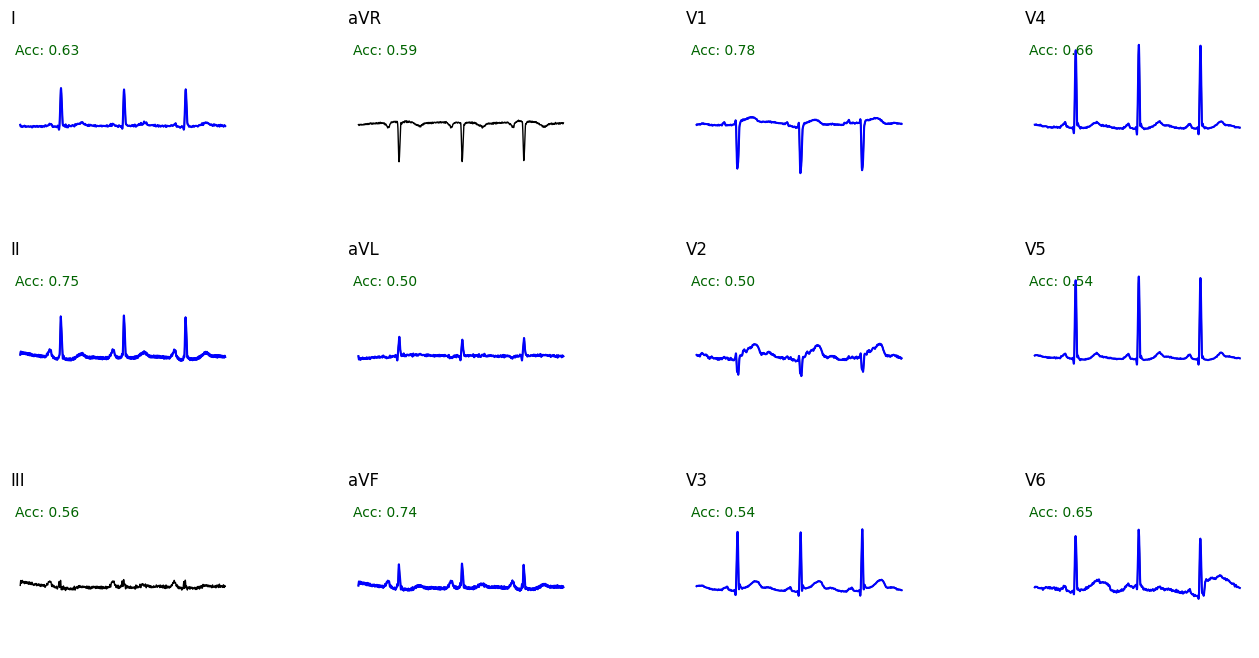

In [148]:
visualize_leads2(df_sinus.iloc[18*306:18*307],1,process_results(final[6]))